In [1]:
import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()

In [2]:
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm

In [3]:
def _download(url, fname, chunk_size=1024):
    '''https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51'''
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

In [4]:
# # Download the example file
# example_file = 'JetClass_example_100k.root'
# if not os.path.exists(example_file):
#     _download('https://hqu.web.cern.ch/datasets/JetClass/example/JetClass_example_100k.root', example_file)

In [5]:
# added

# new
from pathlib import Path

example_file = Path("../../nuisance-aware-ood-detection/sophon/data/JetClass/val_5M/HToBB_120.root")

# Exploring the file

In [6]:
# Load the content from the file
tree = uproot.open(example_file)['tree']

In [7]:
# Display the content of the "tree"
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [8]:
# Load all arrays in the tree
# Each array is a column of the table
table = tree.arrays()

In [9]:
# Arrays of a scalar type (bool/int/float) can be converted to a numpy array directly, e.g.
table['label_QCD'].to_numpy()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [10]:
# Arrays of a vector type are loaded as a JaggedArray that has varying elements per row
table['part_px']

# A JaggedArray can be (zero-) padded to become a regular numpy array (see later)

<Array [[-67.3, -48, ..., 0.0173, -0.52], ...] type='100000 * var * float32'>

In [11]:
# Construct a Lorentz 4-vector from the (px, py, pz, energy) arrays
p4 = vector.zip({'px': table['part_px'], 'py': table['part_py'], 'pz': table['part_pz'], 'energy': table['part_energy']})

In [12]:
# Get the transverse momentum (pt)
p4.pt

<Array [[87.5, 74.4, ..., 0.884, 0.826], ...] type='100000 * var * float32'>

In [13]:
# Get the pseudorapidity (eta)
p4.eta

<Array [[-0.0518, 0.42, ..., -0.000755], ...] type='100000 * var * float32'>

In [14]:
# Get the azimuth angle (phi)
p4.phi

<Array [[2.45, 2.27, 2.23, ..., 1.55, 2.25], ...] type='100000 * var * float32'>

In [15]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x


In [16]:
# Apply zero-padding and convert to a numpy array
_pad(p4.pt, maxlen=128).to_numpy()

array([[ 87.54138 ,  74.36803 ,  68.19881 , ...,   0.      ,   0.      ,
          0.      ],
       [ 82.48453 ,  52.682617,  51.243843, ...,   0.      ,   0.      ,
          0.      ],
       [ 86.492935,  70.19298 ,  58.423912, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [111.11471 ,  79.56289 ,  70.487595, ...,   0.      ,   0.      ,
          0.      ],
       [131.6809  ,  87.84428 ,  61.51071 , ...,   0.      ,   0.      ,
          0.      ],
       [195.14198 , 117.14578 ,  98.17178 , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

# Constructing features and labels

As you see previously with `tree.show()`, there are four groups of arrays with different prefixes:
 - `part_*`: JaggedArrays with features for each particle in a jet. These (and features constrcuted from them) are what we use for training in the Particle Transformer paper.
 - `label_*`: 1D numpy arrays one-hot truth labels for each jet. These are the target of the training.
 - *[Not used in the Particle Transformer paper]* `jet_*`: 1D numpy array with (high-level) features for each jet. These can also be used in the training, but since they are constructed from the particle-level features, it is not expected that they bring additional performance improvement.
 - *[Not used in the Particle Transformer paper]* `aux_*`: auxiliary truth information about the simulated particles for additional studies / interpretations. **SHOULD NOT be used in the training of any classifier.**

The code below illustrates how the input features and labels are constructed in the Particle Transformer paper.

(See also the yaml configuration: https://github.com/jet-universe/particle_transformer/blob/main/data/JetClass/JetClass_full.yaml)

In [17]:
def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [18]:
def build_features_and_labels(tree, transform_features=True):
    
    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log', 
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)
    
    return out

In [19]:
d = build_features_and_labels(tree)
print(d['pf_points'].shape, d['pf_features'].shape, d['pf_vectors'].shape, d['pf_mask'].shape, d['label'].shape)

(100000, 2, 128) (100000, 17, 128) (100000, 4, 128) (100000, 1, 128) (100000, 10)


# Added: Run inference on ParT

In [20]:
# load new data

# ── Cell 0: load multiple ROOT files and build a combined feature dict ─────
from pathlib import Path
import uproot
import numpy as np

# 1) list your files
files = [
    Path("../../nuisance-aware-ood-detection/sophon/data/JetClass/val_5M/HToBB_120.root"),
    Path("../../nuisance-aware-ood-detection/sophon/data/JetClass/val_5M/ZJetsToNuNu_120.root"),
]

# 2) open & build individual dicts
dicts = []
for f in files:
    print("Loading", f.name)
    tree = uproot.open(str(f))["tree"]
    d_i = build_features_and_labels(tree)
    dicts.append(d_i)
    print(" →", d_i["pf_features"].shape[0], "jets")

# 3) concatenate along the event axis
d = {}
for key in dicts[0].keys():
    d[key] = np.concatenate([d_i[key] for d_i in dicts], axis=0)

# 4) same shape printout as before
print(
    d["pf_points"].shape,
    d["pf_features"].shape,
    d["pf_vectors"].shape,
    d["pf_mask"].shape,
    d["label"].shape,
)

Loading HToBB_120.root
 → 100000 jets
Loading ZJetsToNuNu_120.root
 → 100000 jets
(200000, 2, 128) (200000, 17, 128) (200000, 4, 128) (200000, 1, 128) (200000, 10)


In [21]:
# ── Cell 1: env, imports, build feature tensors ──────────────────────────────
import sys, pathlib
import torch
from torch.utils.data import TensorDataset

# add repo root to PYTHONPATH so dataloader & weaver-core import work
REPO_ROOT = pathlib.Path("..").resolve()
sys.path.append(str(REPO_ROOT))

# assume you’ve already done: d = build_features_and_labels(tree)
# now cast into tensors once
x_feat = torch.tensor(d['pf_features']).float()   # (N,17,P)
x_vec  = torch.tensor(d['pf_vectors']).float()    # (N, 4,P)
mask   = torch.tensor(d['pf_mask']).bool()        # (N, 1,P)
labels = torch.tensor(d['label'].argmax(1)).long()# (N,)

# simple dataset object
ds = TensorDataset(x_feat, x_vec, mask, labels)
print("Datasets ready:", len(ds), "jets")

Datasets ready: 200000 jets


In [22]:
# ── Cell 2: DataLoader & device selection ────────────────────────────────────
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# pick the best device
if torch.cuda.is_available():
    device  = torch.device("cuda")
    pin_mem = True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device  = torch.device("mps")
    pin_mem = False
else:
    device  = torch.device("cpu")
    pin_mem = False

print("Using device:", device)

# build loader
batch_size = 2048
ldr = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=pin_mem,
    num_workers=0,
)

# tqdm wrapper (shows progress immediately)
bar = tqdm(ldr, total=len(ldr), desc="Batches")

/Users/jasonweitz/miniconda3/envs/sophon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


Batches:   0%|          | 0/98 [00:00<?, ?it/s]

In [23]:
# ── Cell 3: instantiate ParticleTransformer & load weights ─────────────────
import sys, pathlib, torch
# ensure weaver-core is on PYTHONPATH
WEAVER_PATH = pathlib.Path("..") / "weaver-core"
sys.path.append(str(WEAVER_PATH))

from weaver.nn.model.ParticleTransformer import ParticleTransformer

# must match the checkpoint’s first BN channels
N_FEATURES = 17   # pf_features count
N_CLASSES  = 10   # JetClass-10

model = ParticleTransformer(
    input_dim   = N_FEATURES,
    num_classes = N_CLASSES,
).to(device)

# load checkpoint
ckpt = torch.load(REPO_ROOT/"models"/"ParT_full.pt", map_location=device)
sd   = ckpt.get("model", ckpt)
# strip any "mod." prefixes
clean = {k[len("mod."):]:v for k,v in sd.items()}  
missing, unexpected = model.load_state_dict(clean, strict=False)

print(f"Loaded {len(sd)} weights → missing: {len(missing)}, unexpected: {len(unexpected)}")
model.eval()

Loaded 235 weights → missing: 0, unexpected: 0


ParticleTransformer(
  (trimmer): SequenceTrimmer()
  (embed): Embed(
    (input_bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (embed): Sequential(
      (0): LayerNorm((17,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=17, out_features=128, bias=True)
      (2): GELU(approximate='none')
      (3): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (4): Linear(in_features=128, out_features=512, bias=True)
      (5): GELU(approximate='none')
      (6): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (7): Linear(in_features=512, out_features=128, bias=True)
      (8): GELU(approximate='none')
    )
  )
  (pair_embed): PairEmbed(
    (embed): Sequential(
      (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv1d(4, 64, kernel_size=(1,), stride=(1,))
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): GELU(a

In [29]:
# ── Cell X: shuffle full dataset, then take a small random subset ──────────
import torch
from torch.utils.data import Subset

# 1) pick how many events you want
N_small = 100000

# 2) make a random permutation of all indices (optionally set a seed for reproducibility)
torch.manual_seed(42)
perm = torch.randperm(len(ds))

# 3) select the first N_small of those shuffled indices
small_idx = perm[:N_small].tolist()

# 4) build the Subset from the shuffled indices
small_ds = Subset(ds, small_idx)

# 5) DataLoader over that subset (you can still shuffle within the batch if you like)
from torch.utils.data import DataLoader
ldr_small = DataLoader(
    small_ds,
    batch_size=16,
    shuffle=True,     # shuffle within each epoch
    pin_memory=pin_mem,
    num_workers=0, # change to 4
)

# wrap in tqdm so you see progress
from tqdm.auto import tqdm
bar_small = tqdm(ldr_small, total=len(ldr_small), desc="Small batches")

# small subset inference collecting probabilities
import torch.nn.functional as F

model.eval()
all_probs, all_true = [], []

with torch.no_grad():
    for xf, xv, mm, yy in bar_small:
        xf, xv, mm = xf.to(device), xv.to(device), mm.to(device)
        logits = model(xf, v=xv, mask=mm)
        probs  = F.softmax(logits, dim=1).cpu()
        all_probs.append(probs)
        all_true.append(yy)

all_probs = torch.cat(all_probs)   # (N_small, num_classes)
all_true  = torch.cat(all_true)    # (N_small,)
print("Collected probabilities and labels")

Small batches:   0%|          | 0/6250 [00:00<?, ?it/s]/Users/jasonweitz/miniconda3/envs/sophon/lib/python3.10/site-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/Users/jasonweitz/miniconda3/envs/sophon/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Small batches: 100%|██████████| 6250/6250 [03:33<00:00, 29.26it/s]

Collected probabilities and labels


In [30]:
# print counts with class names
import torch

# 1) Define your class names in index order
class_names = [
    "QCD",    # 0
    "Hbb",    # 1
    "Hcc",    # 2
    "Hgg",    # 3
    "H4q",    # 4
    "Hqql",   # 5
    "Zqq",    # 6
    "Wqq",    # 7
    "Tbqq",   # 8
    "Tbl",    # 9
]

# 2) Get predictions
preds = all_probs.argmax(dim=1)   # tensor of shape (N_small,)

# 3) Count each class
counts = torch.bincount(preds, minlength=len(class_names))
total  = preds.shape[0]

# 4) Print with names
print(f"Out of {total} jets:")
for idx, name in enumerate(class_names):
    cnt = counts[idx].item()
    pct = cnt/total if total>0 else 0
    print(f"  • Class {idx:2d} ({name:5s}): {cnt:5d} jets ({pct:.1%})")

Out of 100000 jets:
  • Class  0 (QCD  ): 41525 jets (41.5%)
  • Class  1 (Hbb  ): 46965 jets (47.0%)
  • Class  2 (Hcc  ):   693 jets (0.7%)
  • Class  3 (Hgg  ):  5865 jets (5.9%)
  • Class  4 (H4q  ):    69 jets (0.1%)
  • Class  5 (Hqql ):    58 jets (0.1%)
  • Class  6 (Zqq  ):  2197 jets (2.2%)
  • Class  7 (Wqq  ):  1168 jets (1.2%)
  • Class  8 (Tbqq ):  1062 jets (1.1%)
  • Class  9 (Tbl  ):   398 jets (0.4%)


AUC (Hbb vs QCD discriminant): 0.997


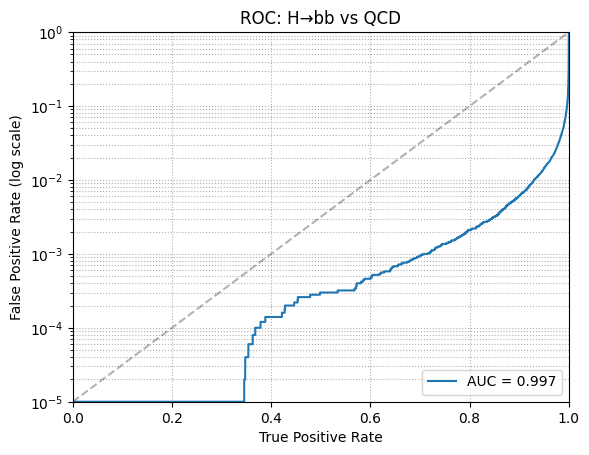

In [39]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1) Convert to numpy arrays
probs_np = all_probs.numpy()
truth_np = all_true.numpy()

# 2) Mask to only QCD (0) vs Hbb (1)
mask = np.isin(truth_np, [0, 1])
y_true = (truth_np[mask] == 1).astype(int)

# 3) Compute the discriminant
p_hbb = probs_np[mask, 1]
p_qcd = probs_np[mask, 0]
disc  = p_hbb / (p_hbb + p_qcd)

# 4) ROC & AUC
fpr, tpr, _ = roc_curve(y_true, disc)
roc_auc = auc(fpr, tpr)
print(f"AUC (Hbb vs QCD discriminant): {roc_auc:.3f}")

# avoid log(0)
eps = 1e-5
fpr_plot = np.clip(fpr, eps, 1.0)

plt.figure()
plt.plot(tpr, fpr_plot, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [eps, 1.0], 'k--', alpha=0.3)  # diagonal reference at y=x
plt.xlim(0, 1)
plt.ylim(eps, 1.0)
plt.xscale('linear')
plt.yscale('log')

plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate (log scale)")
plt.title("ROC: H→bb vs QCD")
plt.legend(loc="lower right")
plt.grid(True, which="both", ls=":")
plt.show()